# Parameter Tuning with The BernoulliNB, Naive Bayes Model

## Joe And Keenan

So far, our best model is the Naive Bayes model which used scikitlearn's BernoulliNB model. We are going to try to tune the parameters to get better results, and hopefully not overfit the model.

________________

Let's start by grabbing all of our data and getting rid of those outliers

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV
import numpy as np
import seaborn as sns

%matplotlib inline

#Load Data with pandas, and parse the first column into datetime
train=pd.read_csv('train.csv', parse_dates = ['Dates'])
test=pd.read_csv('test.csv', parse_dates = ['Dates'])

# Keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
train = train[np.abs(train.X-train.X.mean())<=(3*train.X.std())] 
train = train[np.abs(train.Y-train.Y.mean())<=(3*train.Y.std())] 

train.head()


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


### Process the Data

Let's use the get_dummies() again to binarize the data so we can run models on it

In [18]:
#Convert crime labels to numbers
le_crime = preprocessing.LabelEncoder()
crime = le_crime.fit_transform(train.Category)
 
#Get binarized weekdays, districts, and hours.
days = pd.get_dummies(train.DayOfWeek)
district = pd.get_dummies(train.PdDistrict)
hour = train.Dates.dt.hour
hour = pd.get_dummies(hour) 
x = train.X
y = train.Y
 
#Build new array
train_data = pd.concat([hour, days, district, x, y], axis=1)
train_data['crime']=crime
 
#Repeat for test data
days = pd.get_dummies(test.DayOfWeek)
district = pd.get_dummies(test.PdDistrict)
 
hour = test.Dates.dt.hour
hour = pd.get_dummies(hour) 
x = test.X
y = test.Y
 
test_data = pd.concat([hour, days, district, x, y], axis=1)

print train_data.head()
print test_data.head()

   0  1  2  3  4  5  6  7  8  9  ...    MISSION  NORTHERN  PARK  RICHMOND  \
0  0  0  0  0  0  0  0  0  0  0  ...          0         1     0         0   
1  0  0  0  0  0  0  0  0  0  0  ...          0         1     0         0   
2  0  0  0  0  0  0  0  0  0  0  ...          0         1     0         0   
3  0  0  0  0  0  0  0  0  0  0  ...          0         1     0         0   
4  0  0  0  0  0  0  0  0  0  0  ...          0         0     1         0   

   SOUTHERN  TARAVAL  TENDERLOIN           X          Y  crime  
0         0        0           0 -122.425892  37.774599     37  
1         0        0           0 -122.425892  37.774599     21  
2         0        0           0 -122.424363  37.800414     21  
3         0        0           0 -122.426995  37.800873     16  
4         0        0           0 -122.438738  37.771541     16  

[5 rows x 44 columns]
   0  1  2  3  4  5  6  7  8  9    ...      INGLESIDE  MISSION  NORTHERN  \
0  0  0  0  0  0  0  0  0  0  0    ...          

In [19]:
features = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
 'Wednesday', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION',
 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'X', 'Y']

# Add in hours of the day into the features
features2 = [x for x in range(0,24)]
features = features + features2

print features

['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'X', 'Y', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [20]:
training, validation = train_test_split(train_data, train_size=.5)

model = BernoulliNB()
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
print "Naive Bayes: " , log_loss(validation['crime'], predicted) 

Naive Bayes:  2.58269926046


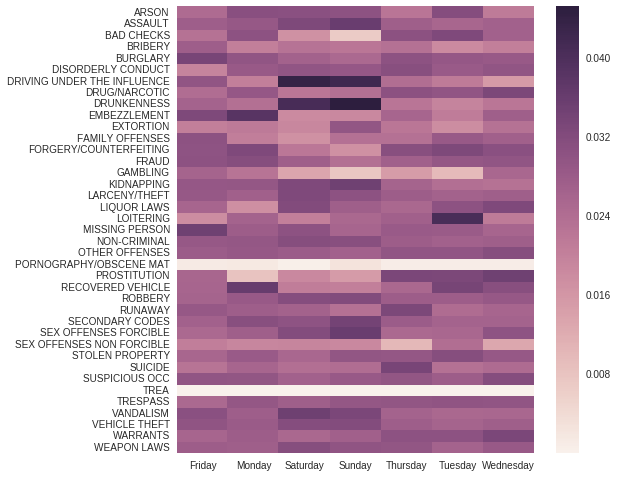

In [21]:
sns.plt.figure(figsize=(8,8))
all_probs = np.zeros((39, 7))
for i in range(7):
    x = np.zeros((1,len(features)))
    x[0,i] = 1.0
    all_probs[:,i] = model.predict_proba(x)
sns.heatmap(all_probs, xticklabels=features, yticklabels=[le_crime.inverse_transform(i) for i in range(39)])

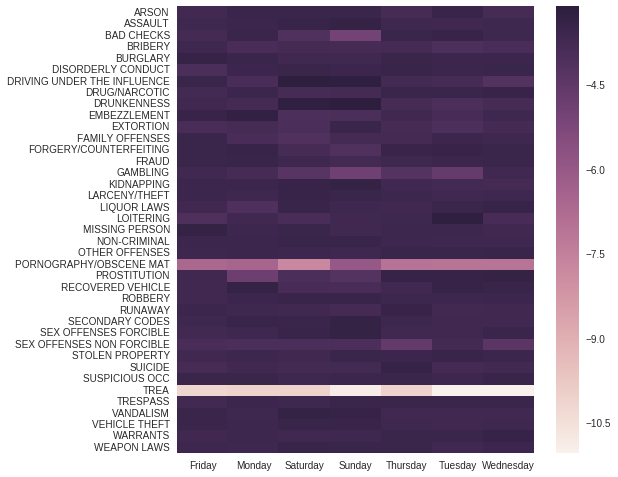

In [22]:
sns.plt.figure(figsize=(8,8))
all_probs = np.zeros((39, 7))
for i in range(7):
    x = np.zeros((1,len(features)))
    x[0,i] = 1.0
    all_probs[:,i] = model.predict_log_proba(x)
sns.heatmap(all_probs, xticklabels=features, yticklabels=[le_crime.inverse_transform(i) for i in range(39)])

Mean:  0.025641025641


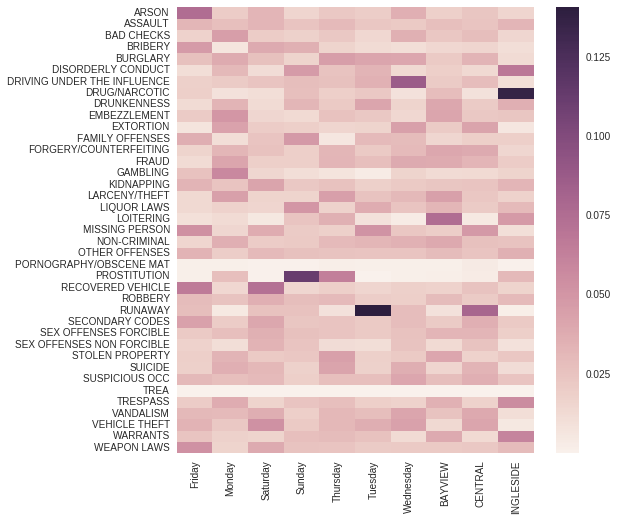

In [23]:
sns.plt.figure(figsize=(8,8))
all_probs = np.zeros((39, 10))
for i in range(7,17):
    x = np.zeros((1,len(features)))
    x[0,i] = 1.0
    all_probs[:,i-7] = model.predict_proba(x)

print "Mean: ", all_probs.mean()
sns.heatmap(all_probs, xticklabels=features, yticklabels=[le_crime.inverse_transform(i) for i in range(39)])

Index([            0,             1,             2,             3,
                   4,             5,             6,             7,
                   8,             9,            10,            11,
                  12,            13,            14,            15,
                  16,            17,            18,            19,
                  20,            21,            22,            23,
           u'Friday',     u'Monday',   u'Saturday',     u'Sunday',
         u'Thursday',    u'Tuesday',  u'Wednesday',    u'BAYVIEW',
          u'CENTRAL',  u'INGLESIDE',    u'MISSION',   u'NORTHERN',
             u'PARK',   u'RICHMOND',   u'SOUTHERN',    u'TARAVAL',
       u'TENDERLOIN',          u'X',          u'Y',      u'crime'],
      dtype='object')
[[-1.95785455 -1.85155989 -1.85999876 ..., -3.26338756 -2.80204199
  -2.86948327]
 [-1.92233787 -1.97290993 -1.86524869 ..., -2.98133238 -2.96402915
  -3.03511445]
 [-1.87413047 -1.73305187 -2.23514381 ..., -4.67749085 -4.67749085
  -5.3706

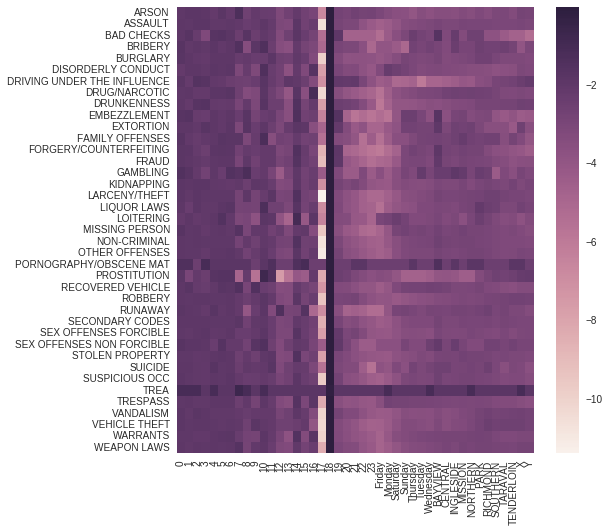

In [24]:
print validation.columns
print model.coef_

sns.plt.figure(figsize=(8,8))
model.classes_
sns.heatmap(model.coef_,
            xticklabels=validation.columns,
            yticklabels=[le_crime.inverse_transform(i) for i in range(39)])

In [25]:
model = LogisticRegression(C=.01)
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
print "Logistic Regression: " , log_loss(validation['crime'], predicted) 

Logistic Regression:  2.58460219093


In [26]:
model = GaussianNB()
model.fit(training[features], training['crime'])
predicted = np.array(model.predict_proba(validation[features]))
print "Gaussian NB: " , log_loss(validation['crime'], predicted) 

Gaussian NB:  31.4026129983


## Alpha Tuning for Bernoulli

/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall 

[mean: 0.13676, std: 0.00021, params: {'alpha': 0.10000000000000001}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.20000000000000001}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.30000000000000004}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.40000000000000002}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.5}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.59999999999999998}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.70000000000000007}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.80000000000000004}, mean: 0.13674, std: 0.00024, params: {'alpha': 0.90000000000000002}, mean: 0.13674, std: 0.00024, params: {'alpha': 1.0}]


/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


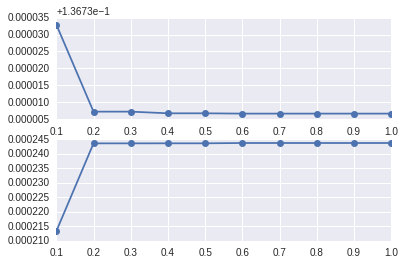

In [27]:
from sklearn.grid_search import GridSearchCV
training, validation = train_test_split(train_data, train_size=.5)

parameters = [{'alpha':np.linspace(0.1,1,10)}]

clf = GridSearchCV(BernoulliNB(), parameters, scoring='f1')
clf.fit(training[features], training['crime']) # running the grid search

print clf.grid_scores_

res = zip(*[(f1m, f1s.std(), p['alpha']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

In [28]:
from sklearn.metrics import f1_score
print 'Best alpha in CV = %0.01f' % clf.best_params_['alpha']



Best alpha in CV = 0.1


In [29]:
training, validation = train_test_split(train_data, train_size=.5)

model1 = BernoulliNB()
model1.fit(training[features], training['crime'])
predicted1 = np.array(model1.predict_proba(validation[features]))
print "Naive Bayes Bernoulli: " , log_loss(validation['crime'], predicted1) 

model2 = BernoulliNB(alpha=0.2)
model2.fit(training[features], training['crime'])
predicted2 = np.array(model2.predict_proba(validation[features]))

print "Naive Bayes Bernoulli with Tuned Alpha: " , log_loss(validation['crime'], predicted2) 



Naive Bayes Bernoulli:  2.5837054269
Naive Bayes Bernoulli with Tuned Alpha:  2.58389696083


As I would have thought from before, tuning the alpha does very little to the model. This variation is so miniscule, it is mostly likely random error that is making the two scores different. 